In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/loan-default-prediction/train_v2.csv.zip
/kaggle/input/loan-default-prediction/sampleSubmission.csv
/kaggle/input/loan-default-prediction/test_v2.csv.zip


**Disclamer:**

The entire notebook is built based on the 2nd place solution, please refer to Github for the original solution: https://github.com/freedomljc/Loan_Default_Prediction

I have modified the predictive models for faster training time due to the original models consume extreme long time (GBR), in exchange it result in poorer public score 0.51714

Kindly upvote if you find it useful :)

# Import Library

In [2]:
import re
import math
import collections
import numpy as np
import time
import operator
from scipy.io import mmread, mmwrite
from random import randint
#from sklearn import cross_validation
from sklearn import linear_model
from sklearn.model_selection import GridSearchCV
#from sklearn import preprocessing as pp
from sklearn.svm import SVR
from sklearn.ensemble import GradientBoostingRegressor, GradientBoostingClassifier
from sklearn.ensemble import  RandomForestRegressor, RandomForestClassifier
from sklearn.ensemble import ExtraTreesRegressor
#from sklearn.decomposition import ProbabilisticPCA, KernelPCA
from sklearn.decomposition import PCA, KernelPCA
from sklearn.decomposition import NMF
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression, Ridge, Lasso, ElasticNet
import scipy.stats as stats
from sklearn import tree
from sklearn.feature_selection import f_regression
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc, f1_score
#from sklearn.gaussian_process import GaussianProcess
#import features -- no required as it is used to import variable from Github py file

# working directory
dir = '.'
label_index = 770

In [3]:
pd.set_option('display.max_rows', 500)

In [4]:
train_fs = pd.read_csv("../input/loan-default-prediction/train_v2.csv.zip", delimiter=',')
train_fs.head()

/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3524: DtypeWarning: Columns (135,204,274,417) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


,id,f1,f2,f3,f4,f5,f6,f7,f8,f9,...,f770,f771,f772,f773,f774,f775,f776,f777,f778,loss
0,1,126,10,0.686842,1100,3,13699,7201.0,4949.0,126.75,...,5,2.14,-1.54,1.18,0.1833,0.7873,1,0,5,0
1,2,121,10,0.782776,1100,3,84645,240.0,1625.0,123.52,...,6,0.54,-0.24,0.13,0.1926,-0.6787,1,0,5,0
2,3,126,10,0.500080,1100,3,83607,1800.0,1527.0,127.76,...,13,2.89,-1.73,1.04,0.2521,0.7258,1,0,5,0
3,4,134,10,0.439874,1100,3,82642,7542.0,1730.0,132.94,...,4,1.29,-0.89,0.66,0.2498,0.7119,1,0,5,0
4,5,109,9,0.502749,2900,4,79124,89.0,491.0,122.72,...,26,6.11,-3.82,2.51,0.2282,-0.5399,0,0,5,0


In [5]:
train_fs.shape

(105471, 771)

In [6]:
test_fs = pd.read_csv("../input/loan-default-prediction/test_v2.csv.zip", delimiter=',')
test_fs.head()

/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3524: DtypeWarning: Columns (417) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


,id,f1,f2,f3,f4,f5,f6,f7,f8,f9,...,f769,f770,f771,f772,f773,f774,f775,f776,f777,f778
0,105472,147,6,0.487058,1100,17.0,75506,964.0,12686.0,152.63,...,-8.71,19,3.30,-9.37,0.50,0.0539,-1.0733,0,1,1079
1,105473,156,6,0.728518,5400,3.0,79754,1455.0,4803.0,153.95,...,-13.26,24,9.53,-7.55,6.22,0.3030,0.6087,0,1,36
2,105474,132,9,0.898133,2200,16.0,113,5735.0,2387.0,130.61,...,-4.99,9,3.25,-2.33,1.69,0.2317,0.4184,0,0,393
3,105475,128,7,0.038411,1300,4.0,3793,4689.0,3469.0,120.50,...,-16.83,11,0.26,-5.31,0.78,0.2826,-0.7711,0,0,394
4,105476,119,10,0.443620,1300,16.0,13026,2788.0,7438.0,127.00,...,-20.00,10,13.55,-0.61,0.01,0.1815,-1.0843,0,0,23


In [7]:
test_fs.shape

(210944, 770)

# Data Exploration

Ref(Data Processing): https://www.kaggle.com/code/kittiyaneerungon/loan-default-prediction

Ref(Feature Engineer & Model): https://github.com/freedomljc/Loan_Default_Prediction

In [8]:
nacheck = pd.DataFrame(train_fs.isnull().sum(),columns=['result'])
nacheck[nacheck['result']>0]

,result
f7,182
f8,101
f14,100
f15,48
f17,159
...,...
f762,158
f763,1840
f765,1
f774,1064


In [9]:
# The number of each data type in the dataframe
train_fs.dtypes.value_counts()

float64    653
int64       99
object      19
dtype: int64

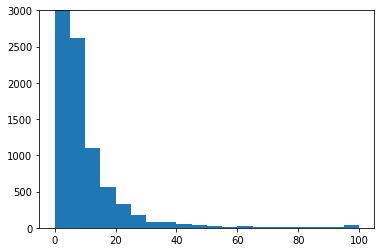

In [10]:
import matplotlib.pyplot as plt

# Loss Distribution
fig , ax = plt.subplots()
plt.hist(train_fs['loss'], bins = 20, range=(0,100))
ax.set_ylim([0,3000])
plt.show()

The loss value distritubtion is Right-Skewed

For example, a loss of 60 means that only 40 is reimbursed. If the loan did not default, the loss was 0. You are asked to predict the losses for each observation in the test set.

Ref:https://www.kaggle.com/competitions/loan-default-prediction/data

In [11]:
# Calculate percent of missing in each column
col_pct_miss = []
for col in train_fs.columns:
    percent_miss = np.mean(train_fs[col].isnull())*100
    if percent_miss > 0:
        col_pct_miss.append([col, percent_miss])
    
col_pct_miss_df = pd.DataFrame(col_pct_miss, columns = ['column_name','% of Missing']).sort_values(by = '% of Missing', ascending = False)
col_pct_miss_df

,column_name,% of Missing
463,f662,17.856093
464,f663,17.856093
127,f159,17.764125
128,f160,17.764125
138,f170,17.461672
...,...,...
476,f677,0.000948
474,f675,0.000948
522,f765,0.000948
477,f678,0.000948


In [12]:
#Check for infinity value
np.isinf(train_fs.select_dtypes(include=['number'])).sum().value_counts()

0    752
dtype: int64

In [13]:
np.isinf(test_fs.select_dtypes(include=['number'])).sum().value_counts()

0    751
dtype: int64

In [14]:
#Correlation for numeric columns
numer = train_fs.select_dtypes(include=['number']).columns
corr_num = {}
for col in numer:
    corr = train_fs['loss'].corr(train_fs[col])
    if not np.isnan(corr):
        corr_num[col] = abs(corr)

sorted(corr_num.items(), key=operator.itemgetter(1),reverse=True)[:20]

[('loss', 1.0),
 ('f471', 0.04003485828917942),
 ('f536', 0.0257082802828102),
 ('f674', 0.019426270154857695),
 ('f612', 0.016573365285605837),
 ('f776', 0.015505606445504232),
 ('f67', 0.014739667638450879),
 ('f670', 0.014594672438313944),
 ('f597', 0.013757525744848424),
 ('f599', 0.013757525744848424),
 ('f68', 0.012986695149725648),
 ('f221', 0.012023809245548264),
 ('f251', 0.011887234545635518),
 ('f556', 0.011431116108247841),
 ('f468', 0.011263763615718058),
 ('f13', 0.011187686488302541),
 ('f675', 0.011158112545609328),
 ('f617', 0.011151818457203606),
 ('f315', 0.011109597461438947),
 ('f353', 0.010760517192075911)]

In [15]:
#Correlation for categorical columns
cat = train_fs.select_dtypes(exclude=['number']).columns
corr_cat = {}
for col in cat:
    corr = train_fs['loss'].corr(train_fs[col].astype('category').cat.codes)
    corr_cat[col] = abs(corr)
sorted(corr_cat.items(), key=operator.itemgetter(1),reverse=True)[:10]

[('f338', 0.005470089757601605),
 ('f276', 0.005281428714661811),
 ('f390', 0.004669187751722686),
 ('f534', 0.0046250922089023155),
 ('f695', 0.004612471604191748),
 ('f419', 0.004609759187433855),
 ('f472', 0.0044119605356509875),
 ('f207', 0.004039014147828838),
 ('f627', 0.0038173679493828127),
 ('f698', 0.0035439404029157435)]

# Data Preprocessing

## Training data

In [16]:
# Impute missing value in numeric columns with mean 
numeric_cols = train_fs.select_dtypes(include=['number']).columns.values

for col in numeric_cols:
    if col in list(col_pct_miss_df.column_name) :
        mean = train_fs[col].mean(skipna=True)
        train_fs[col] = train_fs[col].fillna(mean)

In [17]:
#Remaining columns with missing values is not numeric type
nacheck = pd.DataFrame(train_fs.isnull().sum(),columns=['result'])
nacheck[nacheck['result']>0]

,result
f137,177
f138,182
f206,1291
f207,1291
f276,101
f277,101
f390,698
f391,698
f626,698
f627,698


In [18]:
# Impute NA value in object type columns with zero, all categorical data only contain long digi except 'NA'
not_numeric_cols = train_fs.select_dtypes(exclude=['number']).columns.values

for col in not_numeric_cols:
    if col in list(col_pct_miss_df.column_name):
#         mode = train_fs[col].mode(dropna=True)[0]
        train_fs.loc[train_fs[col]=='NA',col] = 0
#         train_fs[col] = train_fs[col].apply(lambda x:1 if x==mode else 0)

In [19]:
#Convert all categorical data to float type, convert to type Int64 will throw errors in python
for col in cat:
    train_fs[col] = train_fs[col].astype('float64')

train_fs.dtypes.value_counts()

float64    672
int64       99
dtype: int64

In [20]:
#Fill missing value with mean after conversion of object type data
for col in cat:
    mean = train_fs[col].mean(skipna=True)
    train_fs[col] = train_fs[col].fillna(mean)

In [21]:
# Check missing value
train_fs.isnull().sum().value_counts()

0    771
dtype: int64

In [22]:
label_index = 770

train_x = train_fs.iloc[:,range(1, label_index)]
train_y= train_fs.iloc[:,-1]
display(train_x.head())
display(train_y.head())

,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,...,f769,f770,f771,f772,f773,f774,f775,f776,f777,f778
0,126,10,0.686842,1100,3,13699,7201.0,4949.0,126.75,126.03,...,-3.14,5,2.14,-1.54,1.18,0.1833,0.7873,1,0,5
1,121,10,0.782776,1100,3,84645,240.0,1625.0,123.52,121.35,...,-1.38,6,0.54,-0.24,0.13,0.1926,-0.6787,1,0,5
2,126,10,0.500080,1100,3,83607,1800.0,1527.0,127.76,126.49,...,-5.18,13,2.89,-1.73,1.04,0.2521,0.7258,1,0,5
3,134,10,0.439874,1100,3,82642,7542.0,1730.0,132.94,133.58,...,-2.04,4,1.29,-0.89,0.66,0.2498,0.7119,1,0,5
4,109,9,0.502749,2900,4,79124,89.0,491.0,122.72,112.77,...,-11.12,26,6.11,-3.82,2.51,0.2282,-0.5399,0,0,5


0    0
1    0
2    0
3    0
4    0
Name: loss, dtype: int64

## Test Data Set

In [23]:
numeric_cols = test_fs.select_dtypes(include=['number']).columns.values

for col in numeric_cols:
    if col in list(col_pct_miss_df.column_name) :
        mean = test_fs[col].mean(skipna=True)
        test_fs[col] = test_fs[col].fillna(mean)

In [24]:
not_numeric_cols = test_fs.select_dtypes(exclude=['number']).columns.values

for col in not_numeric_cols:
    if col in list(col_pct_miss_df.column_name):
#         mode = test_fs[col].mode(dropna=True)[0]
        test_fs.loc[test_fs[col]=='NA',col] = 0

In [25]:
for col in cat:
    test_fs[col] = test_fs[col].astype('float64')

test_fs.dtypes.value_counts()

float64    673
int64       96
uint64       1
dtype: int64

In [26]:
# Check for remaing columns with missing value
test_fs.isnull().sum().value_counts()
nacheck_test = pd.DataFrame(test_fs.isnull().sum(),columns=['result'])
nacheck_test[nacheck_test['result']>0]

,result
f5,864
f137,376
f138,376
f206,2816
f207,2816
f276,147
f277,152
f390,1226
f391,1226
f395,6


In [27]:
na_col = list(nacheck_test[nacheck_test['result']>0].index)
na_col

['f5',
 'f137',
 'f138',
 'f206',
 'f207',
 'f276',
 'f277',
 'f390',
 'f391',
 'f395',
 'f396',
 'f626',
 'f627',
 'f695',
 'f698',
 'f766',
 'f767']

In [28]:
#Manually update remaing columns that fail to fillna
for col in na_col:
    test_fs[col] = test_fs[col].fillna(test_fs[col].mean(skipna=True))


In [29]:
# Check for missing value again
test_fs.isnull().sum().value_counts()

0    770
dtype: int64

In [30]:
test_x = test_fs.iloc[:,range(1, label_index)]
test_x.head()

,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,...,f769,f770,f771,f772,f773,f774,f775,f776,f777,f778
0,147,6,0.487058,1100,17.0,75506,964.0,12686.0,152.63,115.91,...,-8.71,19,3.30,-9.37,0.50,0.0539,-1.0733,0,1,1079
1,156,6,0.728518,5400,3.0,79754,1455.0,4803.0,153.95,155.50,...,-13.26,24,9.53,-7.55,6.22,0.3030,0.6087,0,1,36
2,132,9,0.898133,2200,16.0,113,5735.0,2387.0,130.61,131.96,...,-4.99,9,3.25,-2.33,1.69,0.2317,0.4184,0,0,393
3,128,7,0.038411,1300,4.0,3793,4689.0,3469.0,120.50,121.93,...,-16.83,11,0.26,-5.31,0.78,0.2826,-0.7711,0,0,394
4,119,10,0.443620,1300,16.0,13026,2788.0,7438.0,127.00,125.98,...,-20.00,10,13.55,-0.61,0.01,0.1815,-1.0843,0,0,23


# Feature Engineering

Original Solution to return feature pairs: https://github.com/freedomljc/Loan_Default_Prediction/blob/master/features.py

In [31]:
feature_pair_sub_list = [[520, 521], [271, 521], [271, 520], [67, 466], [623, 664], [7, 536], [66, 529], [531, 532], [561, 562], [248, 602], [570, 571], [218, 766], [64, 765], [208, 590], [423, 660], [312, 463], [290, 592], [621, 755], [52, 311], [65, 422], [350, 656], [278, 420], [320, 633], [507, 761], [0, 341], [139, 665], [10, 724], [53, 319], [367, 698], [279, 421], [9, 358], [48, 287], [375, 653], [397, 728], [197, 666], [38, 295], [402, 758], [403, 757], [549, 584], [238, 258], [296, 526], [586, 607], [291, 591], [62, 289], [16, 288], [581, 589], [8, 380], [655, 683], [58, 582]]
feature_pair_plus_list = [[466, 529], [664, 759], [602, 766], [64, 665], [279, 590], [397, 592], [311, 621], [248, 755], [660, 768], [218, 666], [65, 278], [549, 607], [16, 402], [53, 757], [463, 526], [197, 312], [507, 762], [320, 619], [367, 380], [10, 350], [62, 401], [52, 756], [610, 633], [0, 656], [319, 758], [38, 50], [288, 296], [67, 584], [48, 611], [422, 724], [249, 591], [58, 686], [287, 295], [341, 589], [208, 728], [66, 508], [44, 605], [4, 358], [9, 695]]
feature_pair_mul_list = [[466, 529], [621, 664], [159, 626], [599, 602], [213, 607], [209, 218], [433, 463], [16, 665], [619, 766], [158, 625], [558, 605], [64, 248], [402, 660], [583, 606], [53, 279], [595, 596], [367, 590], [592, 633], [52, 278], [65, 350], [10, 38], [526, 644], [42, 397], [23, 666], [401, 758], [67, 73], [54, 589], [507, 549], [358, 591], [423, 610], [250, 312], [311, 755], [66, 353], [611, 732], [645, 765], [1, 320], [88, 341], [319, 757], [286, 296], [375, 403], [48, 509], [203, 581], [422, 655], [62, 87], [283, 622], [627, 724], [258, 686], [168, 268], [0, 197], [282, 646], [420, 656]]
feature_pair_divide_list = [[712, 664], [466, 726], [463, 6], [539, 529], [602, 507], [660, 653], [64, 208], [766, 630], [590, 197], [592, 0], [100, 145], [218, 3], [65, 9], [526, 525], [607, 643], [410, 647], [610, 144], [420, 278], [311, 10], [1, 279], [468, 462], [472, 444], [248, 652], [665, 510], [583, 143], [621, 59], [656, 52], [397, 509], [196, 700], [403, 401], [655, 54], [350, 518], [312, 672], [619, 615], [591, 187], [675, 671], [666, 157], [341, 8], [367, 217], [445, 402], [67, 637], [375, 654], [379, 716], [754, 549], [320, 517], [599, 596], [589, 267], [673, 718], [422, 400], [620, 386], [680, 719], [755, 28], [765, 383], [674, 721], [358, 717], [676, 720], [66, 167], [633, 347], [681, 71]]
feature_pair_sub_mul_list=[[271, 521, 1], [520, 521, 622], [7, 536, 218], [656, 664, 619], [664, 712, 621], [664, 719, 278], [664, 731, 401], [67, 466, 529], [466, 726, 65], [466, 754, 591], [664, 671, 402], [71, 664, 403], [342, 664, 280], [351, 664, 421], [623, 664, 666], [359, 664, 440], [368, 664, 510], [376, 664, 279], [414, 664, 420], [466, 539, 589], [424, 664, 665], [33, 664, 397], [466, 559, 10], [405, 664, 422], [664, 760, 439], [39, 664, 509], [55, 664, 620], [49, 664, 672], [66, 466, 549], [634, 664, 141], [267, 466, 433], [664, 703, 328], [60, 466, 64], [386, 664, 399], [38, 466, 633], [128, 466, 590], [615, 664, 511], [44, 466, 58], [107, 466, 157], [62, 466, 48], [7, 546, 248], [314, 507, 466], [531, 532, 209], [59, 664, 70], [126, 466, 367], [45, 664, 197], [246, 466, 118], [7, 556, 607], [117, 466, 592], [265, 466, 350], [97, 466, 156], [664, 702, 88], [7, 566, 258], [53, 466, 52], [215, 766, 466], [466, 584, 108], [236, 466, 72], [116, 466, 358], [61, 466, 56], [664, 704, 87], [311, 466, 28], [176, 466, 206], [29, 466, 631], [255, 466, 341], [247, 466, 0], [260, 466, 245], [664, 708, 98], [664, 696, 447], [664, 701, 601], [256, 466, 337], [664, 751, 431], [43, 466, 42], [46, 466, 36], [466, 602, 438], [40, 466, 717], [106, 466, 226], [319, 466, 758], [664, 697, 432], [410, 466, 686], [466, 741, 8], [250, 466, 235], [664, 693, 74], [86, 466, 630], [664, 752, 166], [18, 466, 632], [561, 562, 64], [313, 466, 54], [466, 746, 210], [466, 635, 9], [19, 466, 57], [63, 466, 517], [11, 466, 37], [237, 466, 216], [14, 466, 365], [664, 738, 127], [12, 466, 506], [96, 466, 338], [664, 709, 167], [326, 466, 764], [121, 466, 382], [47, 466, 15], [320, 466, 16], [664, 747, 227], [257, 466, 659], [186, 466, 139], [77, 529, 463], [321, 466, 375], [177, 466, 147], [187, 466, 217], [185, 466, 195], [294, 466, 660], [312, 466, 23], [664, 698, 225], [7, 575, 605], [266, 466, 650], [318, 466, 651], [664, 710, 599], [664, 739, 240], [17, 466, 348], [466, 582, 276], [664, 700, 441], [664, 694, 230], [404, 664, 393], [664, 748, 515], [570, 571, 64], [466, 767, 380], [287, 466, 356], [466, 706, 196], [295, 466, 339], [664, 740, 670], [664, 711, 627], [111, 466, 78], [50, 466, 654], [445, 466, 146], [448, 602, 768], [664, 699, 753], [664, 749, 277], [296, 466, 723], [406, 664, 394], [664, 695, 518], [188, 466, 190], [466, 587, 735], [466, 750, 285], [286, 466, 759], [664, 742, 220], [289, 466, 643], [165, 466, 366], [407, 664, 392], [155, 466, 21], [288, 466, 349], [109, 466, 175], [664, 743, 661], [664, 737, 207], [30, 607, 213], [664, 761, 3], [259, 466, 249], [178, 466, 373], [81, 466, 652], [322, 664, 101], [323, 664, 137], [238, 466, 27], [324, 664, 428], [325, 664, 91], [180, 466, 25], [68, 466, 653], [430, 466, 646], [79, 466, 357], [140, 664, 396], [327, 602, 745], [302, 466, 340], [31, 607, 558], [315, 664, 644], [32, 607, 214], [34, 607, 241], [35, 607, 242], [607, 668, 243], [607, 690, 244], [607, 691, 551], [607, 692, 552], [664, 730, 669], [310, 602, 655], [408, 664, 395], [297, 466, 26], [2, 602, 744], [526, 602, 757], [100, 602, 755], [160, 466, 24], [610, 766, 208], [189, 466, 170], [179, 466, 150], [316, 664, 138], [586, 607, 624], [317, 664, 614], [119, 602, 763], [526, 765, 645], [149, 466, 73], [99, 602, 756], [229, 602, 762], [110, 466, 400], [370, 664, 5], [602, 736, 732], [455, 463, 612], [664, 667, 270], [120, 602, 682], [466, 502, 595], [148, 466, 374], [228, 602, 681], [305, 602, 718], [611, 766, 516], [423, 660, 4], [89, 602, 369], [219, 602, 678], [239, 466, 715], [472, 602, 657], [168, 766, 353], [80, 466, 385], [158, 466, 22], [303, 602, 679], [90, 602, 720], [169, 602, 647], [664, 724, 362], [281, 660, 347], [159, 602, 680], [290, 664, 398], [492, 602, 683], [291, 664, 613], [292, 664, 20], [583, 602, 721], [293, 664, 384], [298, 664, 629], [508, 602, 675], [602, 606, 299], [602, 603, 300], [585, 602, 301], [463, 482, 381], [602, 714, 282], [304, 602, 360], [602, 713, 676], [588, 602, 673], [664, 728, 383], [568, 660, 538], [425, 660, 372], [221, 660, 222], [223, 660, 224], [572, 660, 577], [541, 660, 533], [542, 660, 251], [231, 660, 252], [232, 660, 253], [233, 660, 254], [234, 660, 261], [594, 602, 677], [593, 602, 722], [64, 364, 268], [306, 664, 355], [663, 664, 618], [563, 660, 553], [409, 466, 307], [450, 660, 13], [308, 664, 389], [345, 664, 729], [548, 660, 262], [474, 660, 346], [468, 660, 442], [82, 660, 628], [92, 660, 444], [309, 664, 637], [449, 660, 51], [93, 660, 462], [94, 660, 471], [487, 660, 596], [83, 660, 443], [486, 660, 598], [95, 660, 436], [84, 660, 597], [85, 660, 6], [608, 664, 275], [477, 660, 361], [484, 660, 454], [478, 660, 481], [496, 660, 491], [497, 660, 501], [102, 660, 263], [103, 660, 264], [104, 660, 75], [105, 660, 434], [724, 727, 642], [476, 660, 636], [112, 660, 354], [457, 660, 498], [113, 660, 363]]
feature_pair_sub_list2=[[520, 521], [271, 521], [271, 520], [67, 466], [623, 664], [7, 536], [66, 529], [531, 532], [561, 562], [248, 602], [570, 571], [218, 766], [64, 765], [208, 590], [423, 660], [312, 463], [290, 592], [621, 755], [52, 311], [65, 422], [350, 656], [278, 420], [320, 633], [507, 761], [0, 341], [139, 665], [10, 724], [53, 319], [367, 698], [279, 421], [9, 358], [48, 287], [375, 653], [397, 728], [197, 666], [38, 295], [402, 758], [403, 757], [549, 584], [238, 258], [296, 526], [586, 607], [291, 591], [62, 289], [16, 288], [581, 589], [8, 380], [655, 683], [58, 582], [54, 587], [377, 657], [44, 81], [292, 735], [610, 706], [177, 401], [109, 249], [187, 756], [425, 768], [293, 723], [61, 631], [365, 730], [378, 658], [100, 239], [37, 47], [12, 632], [313, 318], [541, 542], [268, 718], [36, 46], [28, 700], [306, 763], [79, 611], [361, 722], [727, 762], [11, 506], [588, 686], [99, 267], [360, 721], [717, 759], [431, 432], [679, 720], [508, 605], [282, 391], [285, 745], [23, 519], [445, 599], [379, 716], [250, 255], [176, 326], [4, 314], [348, 671], [110, 229], [166, 167], [15, 29], [230, 235], [585, 764], [198, 283], [157, 650], [219, 767], [307, 744], [308, 315], [309, 316], [400, 743], [496, 497], [455, 472], [317, 669], [413, 689], [87, 128], [196, 327], [281, 356], [488, 498], [92, 102], [93, 103], [94, 104], [95, 105], [410, 736], [257, 266], [373, 652], [642, 732], [228, 441], [17, 137], [42, 179], [704, 712], [719, 751], [107, 305], [408, 622], [88, 118], [731, 752], [220, 265], [3, 200], [71, 339], [56, 178], [82, 484], [494, 504], [212, 516], [342, 697], [351, 404], [353, 370], [13, 132], [337, 619], [628, 742], [359, 702], [368, 709], [651, 737], [376, 708], [414, 638], [424, 710], [240, 245], [33, 406], [405, 693], [637, 760], [385, 614], [39, 73], [55, 711], [49, 407], [286, 634], [346, 371], [389, 618], [160, 195], [259, 749], [45, 59], [645, 646], [502, 699], [40, 635], [492, 695], [347, 740], [274, 464], [111, 175], [215, 386], [149, 190], [615, 629], [272, 461], [146, 748], [449, 450], [338, 703], [430, 739], [310, 747], [459, 499], [18, 19], [277, 694], [476, 477], [148, 150], [302, 322], [323, 382], [14, 324], [57, 325], [517, 738], [43, 701], [336, 418], [465, 489], [138, 276], [83, 468], [448, 696], [205, 426], [294, 298], [299, 753], [300, 511], [127, 301], [144, 214], [204, 467], [608, 609], [170, 741], [143, 734], [133, 398], [191, 675], [192, 680], [269, 284], [237, 256], [80, 155], [193, 678], [194, 673], [130, 676], [21, 543], [134, 202], [142, 681], [662, 663], [363, 667], [135, 273], [331, 332], [674, 677], [112, 474], [199, 682], [275, 412], [168, 217], [345, 362], [460, 470], [171, 563], [490, 500], [247, 559], [172, 548], [366, 558], [173, 231], [174, 232], [270, 411], [181, 514], [161, 233], [162, 234], [169, 189], [343, 352], [211, 213], [84, 486], [344, 687], [85, 487], [182, 369], [163, 568], [164, 572], [512, 513], [183, 577], [349, 533], [612, 684], [184, 525], [151, 546], [152, 556], [153, 566], [154, 575], [27, 553], [446, 705], [384, 613], [515, 729], [5, 644], [25, 451], [86, 225], [241, 357], [221, 251], [222, 252], [223, 253], [224, 254], [493, 503], [552, 672], [26, 242], [180, 216], [523, 535], [243, 340], [24, 244], [261, 538], [89, 90], [262, 374], [263, 630], [264, 715], [428, 551], [117, 156], [201, 524], [51, 433], [60, 419], [522, 528], [647, 670], [627, 733], [131, 544], [534, 564], [434, 596], [545, 555], [78, 573], [77, 554], [185, 364], [136, 520], [495, 505], [435, 597], [2, 390], [113, 457], [120, 478], [114, 594], [115, 321], [603, 604], [260, 565], [303, 574], [547, 595], [209, 392], [396, 557], [537, 567], [576, 639], [41, 560], [165, 518], [297, 550], [96, 121], [122, 482], [119, 123], [91, 124], [116, 125], [437, 600], [569, 578], [30, 415], [746, 750], [76, 443], [393, 643], [453, 469], [456, 483], [442, 725], [74, 438], [203, 527], [479, 480], [98, 540], [458, 485], [141, 661], [31, 236], [394, 620], [32, 640], [473, 475], [34, 354], [452, 462], [713, 714], [72, 330], [659, 726], [580, 648], [75, 707], [35, 427], [329, 754], [97, 108], [186, 668], [395, 399], [6, 471], [246, 690], [510, 593], [101, 444], [439, 691], [20, 688], [454, 692], [106, 481], [147, 491], [126, 501], [436, 583], [416, 530], [226, 227], [598, 606], [383, 685], [50, 69], [509, 539], [328, 624], [68, 654], [158, 159], [63, 641], [304, 372], [355, 649], [280, 636], [188, 333], [625, 626], [1, 417], [206, 440], [22, 387], [129, 429], [334, 381], [70, 616], [145, 335], [140, 210]]
feature_pair_plus_list2=[[466, 529], [664, 759], [602, 766], [64, 665], [279, 590], [397, 592], [311, 621], [248, 755], [660, 768], [218, 666], [65, 278], [549, 607], [16, 402], [53, 757], [463, 526], [197, 312], [507, 762], [320, 619], [367, 380], [10, 350], [62, 401], [52, 756], [610, 633], [0, 656], [319, 758], [38, 50], [288, 296], [67, 584], [48, 611], [422, 724], [249, 591], [58, 686], [287, 295], [341, 589], [208, 728], [66, 508], [44, 605], [4, 358], [9, 695], [54, 99], [100, 258], [425, 577], [3, 655], [581, 765], [8, 694], [519, 658], [267, 582], [587, 706], [290, 420], [717, 730], [282, 561], [177, 238], [36, 326], [727, 763], [423, 543], [599, 631], [283, 657], [516, 689], [235, 764], [109, 187], [291, 608], [137, 767], [51, 292], [214, 721], [293, 346], [200, 268], [157, 289], [219, 229], [623, 653], [281, 533], [570, 732], [138, 745], [314, 667], [663, 761], [315, 421], [375, 400], [565, 722], [228, 305], [514, 718], [79, 176], [316, 510], [280, 317], [212, 720], [652, 671], [110, 441], [313, 403], [41, 744], [284, 465], [251, 646], [175, 632], [209, 743], [179, 196], [390, 712], [364, 622], [28, 723], [506, 650], [37, 195], [571, 683], [211, 426], [42, 170], [132, 677], [640, 742], [71, 643], [662, 737], [472, 736], [682, 705], [265, 559], [5, 332], [525, 680], [536, 678], [546, 675], [69, 342], [15, 318], [56, 255], [556, 673], [641, 719], [545, 716], [700, 729], [298, 609], [669, 735], [299, 410], [80, 239], [459, 734], [300, 354], [141, 749], [440, 731], [377, 513], [107, 121], [351, 419], [140, 359], [368, 439], [376, 509], [372, 414], [381, 424], [33, 217], [405, 518], [636, 760], [46, 150], [461, 578], [216, 257], [39, 445], [55, 139], [49, 399], [620, 634], [149, 156], [74, 699], [133, 547], [604, 740], [460, 687], [189, 386], [207, 615], [90, 748], [353, 703], [17, 259], [418, 512], [178, 739], [432, 698], [301, 747], [322, 404], [352, 535], [59, 323], [324, 407], [325, 408], [417, 464], [523, 684], [455, 738], [435, 676], [87, 190], [601, 701], [76, 681], [345, 702], [45, 186], [406, 752], [447, 704], [237, 697], [167, 751], [159, 696], [369, 453], [148, 693], [411, 733], [285, 365], [81, 588], [467, 616], [603, 709], [206, 708], [710, 741], [146, 327], [348, 638], [247, 711], [134, 524], [647, 679], [443, 674], [451, 558], [271, 378], [412, 434], [310, 337], [450, 541], [449, 542], [82, 231], [83, 232], [84, 233], [85, 234], [135, 335], [213, 437], [477, 566], [476, 575], [7, 112], [478, 552], [113, 261], [114, 262], [115, 263], [241, 457], [361, 574], [427, 528], [111, 128], [488, 548], [360, 520], [242, 494], [484, 562], [343, 521], [252, 487], [253, 486], [92, 254], [356, 642], [553, 624], [93, 264], [94, 243], [95, 244], [415, 557], [88, 302], [468, 551], [215, 502], [198, 391], [446, 544], [362, 563], [585, 726], [495, 560], [573, 725], [30, 245], [452, 564], [370, 572], [474, 568], [339, 645], [379, 555], [483, 567], [23, 205], [522, 554], [538, 654], [473, 576], [75, 413], [155, 168], [504, 531], [498, 532], [166, 180], [344, 480], [493, 537], [122, 221], [123, 222], [124, 223], [125, 224], [534, 600], [492, 651], [236, 260], [19, 127], [57, 392], [485, 569], [31, 586], [86, 108], [14, 511], [505, 550], [225, 595], [330, 442], [202, 456], [61, 63], [126, 246], [6, 329], [458, 540], [47, 396], [306, 659], [334, 475], [21, 644], [490, 648], [89, 750], [527, 685], [43, 627], [479, 707], [12, 433], [158, 227], [60, 393], [444, 625], [294, 753], [366, 672], [18, 185], [371, 628], [596, 626], [389, 470], [11, 169], [210, 307], [188, 308], [309, 328], [40, 539], [203, 688], [22, 454], [374, 481], [1, 491], [438, 501], [436, 639], [387, 530], [431, 598], [129, 489], [349, 373], [469, 597], [70, 462], [72, 471], [333, 649], [276, 338], [68, 226], [32, 713], [409, 496], [429, 497], [102, 304], [103, 256], [104, 118], [105, 355], [266, 515], [204, 416], [106, 606], [363, 428], [77, 382], [27, 171], [29, 635], [25, 172], [277, 448], [173, 357], [117, 250], [26, 174], [331, 499], [73, 637], [230, 240], [272, 503], [116, 160], [142, 269], [2, 78], [145, 500], [714, 754], [161, 340]]
feature_pair_sub_list_sf=[[271, 521], [520, 521], [271, 520], [592, 608], [238, 248], [186, 766], [60, 311], [176, 218], [9, 397], [248, 750], [90, 529], [396, 766], [660, 724], [108, 507], [107, 660], [65, 320], [577, 660], [271, 521], [10, 455], [64, 126], [56, 312], [664, 757], [518, 590], [511, 602], [65, 298], [259, 665], [12, 590], [529, 582], [291, 589], [187, 660], [296, 526], [64, 159], [170, 320], [64, 724], [65, 187], [508, 665], [298, 660], [358, 752], [592, 706], [25, 664], [397, 619], [466, 691], [52, 664], [665, 736], [350, 609], [665, 666], [664, 669], [248, 602], [66, 666], [118, 463], [311, 590], [64, 346], [309, 590], [312, 506], [319, 611], [660, 750], [65, 185], [706, 757], [764, 766], [271, 520], [394, 466], [150, 319], [367, 636], [611, 621], [64, 265], [186, 602], [10, 509], [89, 350], [590, 605], [312, 508], [101, 311], [358, 710], [399, 591], [664, 756], [507, 699], [229, 312], [98, 466], [661, 757], [165, 463], [62, 350], [328, 592], [586, 660], [68, 665], [156, 350], [633, 664], [218, 713], [311, 607], [187, 757], [511, 766], [338, 466], [559, 664], [63, 664], [318, 507], [509, 664], [659, 660], [64, 753], [249, 664], [169, 320], [10, 209], [584, 660], [422, 665], [394, 664], [19, 590], [341, 703], [101, 466], [231, 660], [41, 64], [38, 590], [350, 445], [7, 546], [350, 711], [631, 664], [188, 664], [65, 177], [100, 296], [410, 660], [50, 766], [287, 766], [187, 665], [24, 660], [160, 350], [34, 507], [303, 529], [472, 660], [421, 422], [549, 621], [81, 466], [660, 736], [61, 590], [664, 668], [515, 602], [99, 350], [260, 350], [246, 466], [71, 664], [660, 663], [302, 602], [220, 664], [310, 350], [259, 602], [431, 660], [558, 660], [120, 766], [665, 761], [64, 91], [179, 248], [36, 664], [664, 735], [16, 466], [10, 237], [107, 766], [66, 592], [592, 691], [338, 602], [177, 466], [33, 367], [350, 433], [64, 403], [220, 602], [12, 529], [106, 664], [65, 100], [216, 602], [507, 627], [656, 696], [196, 529], [373, 660], [350, 761], [529, 713], [466, 593], [77, 660], [86, 397], [305, 367], [63, 367], [638, 664], [175, 665], [305, 466], [72, 367], [520, 521], [220, 660], [64, 510], [96, 367], [10, 724], [367, 706], [248, 287], [185, 397], [64, 621], [303, 466], [91, 592], [466, 664], [86, 590], [438, 507], [64, 754], [65, 539], [42, 590], [341, 342], [36, 590], [176, 529], [286, 592], [150, 279], [350, 714], [65, 656], [38, 766], [656, 752], [431, 664], [583, 665], [472, 664], [197, 466], [726, 766], [592, 692], [656, 660], [266, 507], [180, 592], [660, 758], [367, 608], [448, 466], [96, 590], [445, 592], [350, 754], [287, 466], [229, 766], [116, 397], [260, 590], [466, 585], [87, 279], [57, 665], [187, 367], [37, 529], [10, 37], [64, 208], [602, 754], [186, 279], [15, 664], [65, 661], [86, 463], [196, 507], [45, 664], [67, 690], [65, 206], [267, 591], [466, 515], [397, 746], [294, 766], [237, 367], [589, 592], [502, 766], [37, 320], [367, 763], [507, 729], [397, 627], [109, 755], [64, 90], [180, 466], [65, 604], [257, 766], [207, 592], [168, 602], [176, 248], [506, 660], [276, 397], [636, 660], [664, 764], [179, 463], [100, 466], [457, 660], [420, 660], [250, 590], [255, 602], [638, 660], [367, 509], [40, 279], [507, 609], [98, 766], [603, 665], [318, 529], [64, 401], [126, 590], [166, 590], [218, 508], [393, 507], [63, 766], [276, 507], [41, 664], [341, 761], [311, 714], [111, 664], [169, 766], [341, 376], [10, 80], [97, 466], [552, 660], [664, 703], [295, 529], [664, 692], [323, 664], [250, 602], [96, 766], [287, 602], [219, 466], [79, 660], [585, 766], [250, 529], [313, 665], [590, 659], [278, 420], [32, 466], [10, 706], [147, 350], [10, 311], [289, 766], [43, 466], [10, 585], [246, 463], [350, 712], [10, 309], [397, 441], [432, 664], [664, 693], [583, 664], [29, 602], [35, 311], [235, 660], [41, 507], [397, 668], [325, 350], [466, 746], [342, 664], [67, 607], [238, 757], [63, 590], [52, 296], [32, 660], [265, 463], [15, 312], [397, 447], [227, 602], [65, 394], [10, 109], [219, 660], [665, 767], [110, 466], [88, 660], [664, 742], [96, 397], [586, 664], [664, 694], [358, 615], [298, 590], [279, 296], [65, 750], [65, 101], [185, 311], [64, 539], [52, 288], [72, 664], [366, 664], [218, 311], [117, 664], [326, 766], [466, 590], [592, 754], [54, 664], [226, 529], [65, 447], [74, 665], [507, 753], [279, 744], [219, 592], [67, 529], [91, 602], [111, 367], [664, 738], [279, 316], [249, 665], [65, 757], [350, 763], [602, 714], [305, 660], [8, 367], [110, 367], [8, 375], [664, 736], [15, 602], [137, 665], [65, 313], [219, 507], [345, 664], [312, 764], [236, 248], [116, 664], [350, 651], [32, 218], [664, 746], [302, 592], [220, 279], [99, 766], [195, 664], [278, 664], [265, 466], [227, 529], [650, 664], [206, 466], [296, 589], [218, 583], [664, 700], [279, 286], [62, 367], [248, 367], [64, 78], [209, 507], [218, 660], [279, 314], [518, 664], [10, 633], [515, 590], [139, 397], [507, 668], [666, 741], [64, 294], [259, 660], [350, 518], [2, 507], [341, 737], [394, 660], [65, 763], [10, 439], [150, 312], [250, 311], [41, 65], [139, 350], [64, 629], [66, 549], [313, 529], [118, 766], [401, 660], [107, 350], [167, 590], [64, 176], [180, 350], [67, 279], [262, 660], [660, 704], [15, 64], [67, 590], [240, 660], [466, 539], [77, 397], [466, 765], [350, 407], [297, 766], [127, 367], [306, 660], [100, 320], [9, 350], [47, 507], [338, 592], [53, 592], [367, 712], [51, 665], [65, 226], [91, 664], [10, 371], [65, 765], [10, 299], [65, 139], [438, 664], [230, 466], [367, 760], [62, 319], [155, 320], [33, 664], [121, 466], [260, 320], [602, 755], [327, 664], [582, 755], [549, 691], [16, 296], [508, 660], [403, 666], [35, 64], [16, 602], [108, 466], [238, 350], [88, 602], [590, 666], [65, 744], [64, 611], [240, 529], [320, 606], [107, 529], [159, 466], [177, 665], [186, 529], [108, 592], [664, 712], [52, 592], [515, 660], [47, 311], [197, 633], [425, 660], [396, 529], [150, 660]]

In [32]:
#f_regression to find correlation, dict.iteritems() deprecate in python3
def getTopFeatures(train_x, train_y, n_features=100):
    f_val, p_val = f_regression(train_x,train_y)
    f_val_dict = {}
    p_val_dict = {}
    for i in range(len(f_val)):
        if math.isnan(f_val[i]):
            f_val[i] = 0.0
        f_val_dict[i] = f_val[i]
        if math.isnan(p_val[i]):
            p_val[i] = 0.0
        p_val_dict[i] = p_val[i]
    
    sorted_f = sorted(f_val_dict.items(), key=operator.itemgetter(1),reverse=True)
    sorted_p = sorted(p_val_dict.items(), key=operator.itemgetter(1),reverse=True)
    
    feature_indexs = []
    for i in range(0,n_features):
        feature_indexs.append(sorted_f[i][0])
    
    return feature_indexs

In [33]:
feature_indexs = getTopFeatures(train_x, train_y)

/opt/conda/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: divide by zero encountered in true_divide
  correlation_coefficient /= X_norms
/opt/conda/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: invalid value encountered in true_divide
  correlation_coefficient /= X_norms
/opt/conda/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:358: RuntimeWarning: invalid value encountered in true_divide
  f_statistic = corr_coef_squared / (1 - corr_coef_squared) * deg_of_freedom


In [34]:
# generate the new data, based on which features are generated, and used
def get_data(train_x, feature_indexs, feature_minus_pair_list=[], feature_plus_pair_list=[],
            feature_mul_pair_list=[], feature_divide_pair_list = [], feature_pair_sub_mul_list=[],
            feature_pair_plus_mul_list = [],feature_pair_sub_divide_list = [], feature_minus2_pair_list = [],feature_mul2_pair_list=[], 
            feature_sub_square_pair_list=[], feature_square_sub_pair_list=[],feature_square_plus_pair_list=[]):
    sub_train_x = train_x.iloc[:,feature_indexs].to_numpy()
    for i in range(len(feature_minus_pair_list)):
        ind_i = feature_minus_pair_list[i][0]
        ind_j = feature_minus_pair_list[i][1]
        sub_train_x = np.column_stack((sub_train_x, train_x.iloc[:,ind_i]-train_x.iloc[:,ind_j]))
    
    for i in range(len(feature_plus_pair_list)):
        ind_i = feature_plus_pair_list[i][0]
        ind_j = feature_plus_pair_list[i][1]
        sub_train_x = np.column_stack((sub_train_x, train_x.iloc[:,ind_i] + train_x.iloc[:,ind_j]))

#Submission score (SVR only) is 0.54 by using above 2 features, 0.64 with mul_pair_list, 0.8 with all extra features
    for i in range(len(feature_mul_pair_list)):
        ind_i = feature_mul_pair_list[i][0]
        ind_j = feature_mul_pair_list[i][1]
        sub_train_x = np.column_stack((sub_train_x, train_x.iloc[:,ind_i] * train_x.iloc[:,ind_j]))
    
    for i in range(len(feature_divide_pair_list)):
        ind_i = feature_divide_pair_list[i][0]
        ind_j = feature_divide_pair_list[i][1]
        sub_train_x = np.column_stack((sub_train_x, train_x.iloc[:,ind_i] / train_x.iloc[:,ind_j]))
    
    for i in range(len(feature_pair_sub_mul_list)):
        ind_i = feature_pair_sub_mul_list[i][0]
        ind_j = feature_pair_sub_mul_list[i][1]
        ind_k = feature_pair_sub_mul_list[i][2]
        sub_train_x = np.column_stack((sub_train_x, (train_x.iloc[:,ind_i]-train_x.iloc[:,ind_j]) * train_x.iloc[:,ind_k]))
        
    return sub_train_x

In [35]:
#Sub train data for classification
sub_x_Train_clf = get_data(train_x, feature_indexs[:16], feature_pair_sub_list
            ,feature_pair_plus_list, feature_pair_mul_list, feature_pair_divide_list[:20], feature_pair_sub_mul_list[:20])
sub_x_Train_clf

array([[ 1.17000e+00,  1.13000e+00,  3.30000e+01, ..., -8.12000e+01,
        -7.39200e+01,  7.29000e-02],
       [ 1.20000e+00,  1.18000e+00,  4.30000e+01, ..., -3.50390e+02,
        -3.84430e+02,  7.29000e-02],
       [ 1.17000e+00,  1.16000e+00,  1.00000e+02, ..., -4.43700e+02,
        -5.14605e+02,  2.43000e-02],
       ...,
       [ 1.14000e+00,  1.15000e+00,  7.00000e+00, ..., -2.14200e+01,
        -1.78350e+01, -4.12000e-02],
       [ 1.17000e+00,  1.12000e+00,  3.00000e+01, ..., -3.30400e+02,
        -4.76000e+02,  0.00000e+00],
       [ 1.16000e+00,  1.15000e+00,  8.00000e+00, ..., -1.36500e+01,
        -2.52300e+01,  4.12000e-02]])

In [36]:
#Check for 1st stacking result, less columns after stacking due to only extract top 100 features from train DF,
sub_x_Train_clf.shape

(105471, 195)

In [37]:
#Sub train data for model prediction
sub_x_Train_pre = get_data(train_x, feature_indexs[:100], feature_pair_sub_list_sf
    ,feature_pair_plus_list2[:100], feature_pair_mul_list[:40], feature_pair_divide_list, feature_pair_sub_mul_list)
sub_x_Train_pre.shape

(105471, 1093)

In [38]:
sub_x_Test_clf = get_data(test_x, feature_indexs[:16], feature_pair_sub_list
            ,feature_pair_plus_list, feature_pair_mul_list, feature_pair_divide_list[:20], feature_pair_sub_mul_list[:20])
sub_x_Test_clf.shape

(210944, 195)

In [39]:
sub_x_Test_pre = get_data(test_x, feature_indexs[:100], feature_pair_sub_list_sf
    ,feature_pair_plus_list2[:100], feature_pair_mul_list[:40], feature_pair_divide_list, feature_pair_sub_mul_list)
sub_x_Test_pre.shape

(210944, 1093)

In [40]:
#Return value for default loan (loss > 0) with 1
def toLabels(train_y):
    labels = np.zeros(len(train_y))
    labels[train_y>0] = 1
    return labels

In [41]:
#Only minority loans are default, the targets are imbalanced dataset
labels = toLabels(train_y)
pd.DataFrame(labels).value_counts()

0.0    95688
1.0     9783
dtype: int64

# Model

## Loan default status classification

In [42]:
from sklearn.preprocessing import RobustScaler
rs = RobustScaler()
sc = rs.fit_transform(sub_x_Train_clf)

Dealing with Imbalanced target: https://towardsdatascience.com/working-with-highly-imbalanced-datasets-in-machine-learning-projects-c70c5f2a7b16

However, attempt to give heavy weight to minority status for RF may result in poorer submission. Gradientboostingclassifier is preferred method in all case but it take extreme long time to train the model.

In [43]:
# rc = RandomForestClassifier(class_weight={0:1,1:85},n_estimators=500,max_depth=7,n_jobs=-1,random_state=42)
rc = RandomForestClassifier(n_estimators=145,max_depth=18,n_jobs=-1,random_state=42,min_samples_split=4)
rc.fit(sc,labels)
rc_pre = rc.predict(sc)

In [44]:
# from sklearn.model_selection import KFold

# kfolds = KFold(n_splits=5, shuffle=True, random_state=42)

# model = LogisticRegression(solver='sag',max_iter=10000,class_weight='balanced',random_state=42,n_jobs=-1)
# params = {"C":[1,0.8,0.6,0.5,0.3],'penalty':['l1','l2']}

# gs = GridSearchCV(model,param_grid=params,cv=kfolds)
# gs.fit(sc,labels)
# print(gs.best_score_)
# print(gs.best_estimator_)

In [45]:
from sklearn.metrics import accuracy_score
accuracy_score(labels,rc_pre)

0.999506973480862

The accuracy score of 99% hint that the model is overfitting, but it is sufficient for education purpose

In [46]:
# use gbm classifier to predict whether the loan defaults or not
# gbc = GradientBoostingClassifier(n_estimators=3000, max_depth=8)
# gbc.fit(sub_x_Train_clf, labels)

In [47]:
sc_test = rs.transform(sub_x_Test_clf)
pred_labels = rc.predict(sc_test)

In [48]:
#Obtain index where the test data is default loan
ind_test = np.where(pred_labels==1)[0]
ind_test

array([     3,      5,     12, ..., 210920, 210939, 210940])

In [49]:
#Obtain index where the train data is default loan
ind_train = np.where(train_y > 0)[0]
ind_train

array([     7,     16,     26, ..., 105440, 105456, 105463])

In [50]:
#Obtain index where loan is not default
ind_train0 = np.where(train_y == 0)[0]
print(len(ind_train0))
ind_test0 = np.where(pred_labels==0)[0]
print(len(ind_test0))

95688
178892


## Loss Value Prediction

### Support Vector Regression

In [51]:
#Only transform test data with predicted default status
scaler = RobustScaler()
sub_x_Train = scaler.fit_transform(sub_x_Train_pre)
sub_x_Test_pre[ind_test] = scaler.transform(sub_x_Test_pre[ind_test])

In [52]:
svr = SVR(C=16, kernel='rbf', gamma =  0.000122)
svr.fit(sub_x_Train[ind_train], np.log(train_y[ind_train]))

SVR(C=16, gamma=0.000122)

In [53]:
from sklearn.metrics import mean_squared_log_error

In [54]:
#Evaluate model performance against train dataset, the score is 0.20

# preds = svr.predict(sub_x_Train[ind_train])
# preds_all = np.zeros(train_fs.shape[0])
# preds_all[ind_train] = np.power(np.e, preds)
# preds_all[ind_train0] = 0

# mean_squared_log_error(train_y.values,preds_all)

In [55]:
#Generate Test prediction
predict = svr.predict(sub_x_Test_pre[ind_test])
prediction_svr = np.zeros(test_fs.shape[0])
prediction_svr[ind_test] = np.power(np.e, predict)
prediction_svr[ind_test0] = 0
prediction_svr

array([0., 0., 0., ..., 0., 0., 0.])

### Linear Model

Not adopted as it will return more than 5% prediction with extreme high loss (>100e), svr will not have this issue. Targeted loss value is discrete value

In [56]:
#Gridsearch method to find best param for Ridge Model, alpha 0.4
# parameters = {'alpha':[1,0.8,0.6,0.4]}
# clf = GridSearchCV(rg, parameters,n_jobs=-1, cv=5,verbose=1)
# clf.fit(sub_x_Train[ind_train], np.log(train_y[ind_train]))
# clf.best_params_
# clf.best_score_

### XG Boost Model

In [57]:
import xgboost as xgb
from sklearn.model_selection import train_test_split

params = {"objective": "reg:linear", # for linear regression
          "booster" : "gbtree",   # use tree based models 
          "eta": 0.005,   # learning rate
          "max_depth": 10,    # maximum depth of a tree
          "subsample": 0.9,    # Subsample ratio of the training instances
          "colsample_bytree": 0.7,   # Subsample ratio of columns when constructing each tree
          "silent": 1,   # silent mode
          "seed": 10   # Random number seed
          }

In [58]:
#For validation purpose, Model stop validation at round 1749
# num_boost_round = 4000

# dtrain_x, dtest_x, dtrain_y, dtest_y = train_test_split(sub_x_Train[ind_train],np.log(train_y[ind_train]),test_size=0.2,random_state=42)
# dtrain = xgb.DMatrix(dtrain_x, dtrain_y)
# dvalid = xgb.DMatrix(dtest_x, dtest_y)
# watchlist = [(dtrain, 'train'), (dvalid, 'eval')]
# # train the xgboost model
# model = xgb.train(params, dtrain, num_boost_round, evals=watchlist, early_stopping_rounds= 10, verbose_eval=True)

In [59]:
num_boost_round = 1749

dtrain = xgb.DMatrix(sub_x_Train[ind_train],np.log(train_y[ind_train]))

model = xgb.train(params, dtrain, num_boost_round)

[10:24:20] WARNING: ../src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[10:24:20] WARNING: ../src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




In [60]:
#Evaluate overall performance
# dtrain_check = xgb.DMatrix(sub_x_Train[ind_train])
# preds_xg = model.predict(dtrain_check)
# preds_all_xg = np.zeros(train_fs.shape[0])
# preds_all_xg[ind_train] = np.power(np.e, preds_xg)
# preds_all_xg[ind_train0] = 0
# mean_squared_log_error(train_y.values,preds_all_xg)

In [61]:
#Generate Test prediction
test_Dmatrix = xgb.DMatrix(sub_x_Test_pre[ind_test])
predict = model.predict(test_Dmatrix)
prediction_xg = np.zeros(test_fs.shape[0])
prediction_xg[ind_test] = np.power(np.e, predict)
prediction_xg[ind_test0] = 0
pd.DataFrame(prediction_xg).describe()

,0
count,210944.000000
mean,1.000578
std,2.644043
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,48.173100


### Gradient Boosting Regressor

Not adopted due to extreme long training time with large features

In [62]:
# gbr1000 = GradientBoostingRegressor(n_estimators=1300, max_depth=4, subsample=0.5, learning_rate=0.05)
# gbr1000.fit(sub_x_Train[ind_train], np.log(train_y[ind_train]))

## Final Prediction

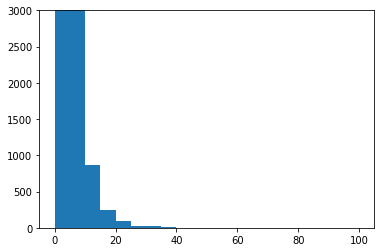

,0
count,210944.000000
mean,0.905795
std,2.376017
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,75.100529


In [63]:
pred_all = prediction_xg * 0.5 + prediction_svr * 0.5
fig , ax = plt.subplots()
plt.hist(pred_all, bins = 20, range=(0,100))
ax.set_ylim([0,3000])
plt.show()        
        
pd.DataFrame(pred_all).describe()

# Submission

In [64]:
test_fs['loss'] = pred_all

In [65]:
sample_submission = test_fs[['id','loss']]
sample_submission.to_csv('sample_submission_rf.csv', index = False)

**References:**

Feature Engineering & Models (Main): https://github.com/freedomljc/Loan_Default_Prediction

Data Preprocessing: https://www.kaggle.com/code/kittiyaneerungon/loan-default-prediction

Further Study (Winner solution R & Pdf): https://www.kaggle.com/competitions/loan-default-prediction/discussion/7398#41007

Other good solution: https://github.com/dmcgarry/Default_Loan_Prediction